# Bumper experiments analysis
## GOAL
The goal of this document is to load, extract, aggregate and analyze data from the experiments run with Bumper pipelines (base, standard, advanced) and gain useful insights on what can be useful in APR for dependency updates.

## Experiments structure
Bumper is evaluated on the BUMP benchmark, in three pipeline versions (base, standard and advanced).

In [64]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import json

In [65]:
# Define the pipeline versions and experiment ids
pipelines = ["baseline", "standard", "advanced"]
experiment_ids = {
    'without_diff': "20240524_without_diff",
    "with_diff": "20240524_with_diff",
}
models = ["gpt4", "gemini", "mixtral", "llama"]

## Helper Functions

In [66]:
def load_report(pipeline, experiment_id, model):
    path = f"benchmark/{experiment_id}/bump/{pipeline}/{model}/report.json"

    if not os.path.exists(path):
        print(f"{path} does not exist")
        exit(1)
        return None

    with open(path, "r") as f:
        result = json.loads(f.read())
        f.close()
        return result


def get_stats_from_report(report):
    result = {
        "number_of_projects": 0,
        "number_of_repaired_projects": 0,
        "number_of_generated_patches": 0,
        "number_of_errors": 0,
        "number_of_repaired_errors": 0,
        "avg_repair_progress": 0
    }

    for k in report:
        project = report.get(k)
        result["avg_repair_progress"] = (
            (
                    (result["avg_repair_progress"] * result["number_of_projects"]) + min(1, project["fixed_errors_count"] / max(project["fixed_errors_count"] + project["final_errors_count"], 1))
            ) / (
                result["number_of_projects"] + 1
            )
        )
        result["number_of_projects"] += 1
        result["number_of_repaired_projects"] += (1 if project["repaired"] else 0)
        result["number_of_generated_patches"] += project["generated_patch_count"]
        result["number_of_errors"] += (project["fixed_errors_count"] + project["final_errors_count"])
        result["number_of_repaired_errors"] += project["fixed_errors_count"]
        
    result["avg_patches_per_repair"] = result["number_of_generated_patches"] / result["number_of_repaired_errors"]

    return result


def get_stats_per_model(pipeline, experiment):
    data = {}
    for model in models:
        data[model] = get_stats_from_report(load_report(pipeline, experiment_ids[experiment], model))
    return data


def get_stats_per_project(pipeline, experiment):
    data = {}
    for model in models:
        report = load_report(pipeline, experiment_ids[experiment], model)
        for project in report:
            if data.get(project, None) is None:
                data[project] = {}

            data[project][model] = report[project]
    return data

def plot_stats(stats, filename = None):
    df = pd.DataFrame.from_dict(stats, orient="index")
    colors = ["r", "b", "g", "black"]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
    fig.tight_layout(pad=2.5)
    df["avg_repair_progress"].plot(ax=axes[0][0], kind='barh',stacked=False,title='Average progress in repair', color=colors)
    axes[0][0].set_xticks([x / 100.0 for x in range(0, 101, 25)])
    
    df["number_of_generated_patches"].plot(ax=axes[0][1], kind ='barh',stacked=False,title='Number of Generated Patches', color=colors)
    df["number_of_repaired_projects"].plot(
        ax=axes[1][0],
        kind='barh',
        stacked=False,
        title='Number of Repaired Projects', 
        color=colors,
    )
    axes[1][0].set_xticks(range(0, 40, 5))
    
    df["number_of_repaired_errors"].plot(ax=axes[1][1], kind='barh',stacked=False,title='Number of Repaired Errors', color=colors)
    if filename is not None:
        fig.savefig(f"images/{filename}.png")
    

# Base pipeline performance
## Without api diff (Baseline)

In [67]:
stats = get_stats_per_model("baseline", "without_diff")
pd.DataFrame(stats)

,gpt4,gemini,mixtral,llama
number_of_projects,35.000000,35.000000,35.000000,35.000000
number_of_repaired_projects,1.000000,2.000000,1.000000,2.000000
number_of_generated_patches,364.000000,232.000000,169.000000,326.000000
number_of_errors,190.000000,122.000000,96.000000,173.000000
number_of_repaired_errors,115.000000,47.000000,37.000000,91.000000
avg_repair_progress,0.302579,0.290794,0.270918,0.383469
avg_patches_per_repair,3.165217,4.936170,4.567568,3.582418


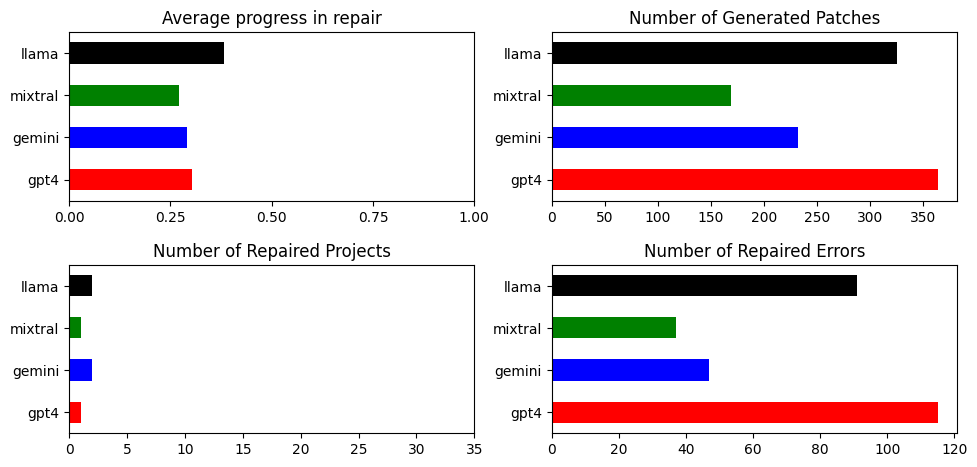

In [68]:
stats = get_stats_per_model("baseline", "without_diff")
plot_stats(stats, "baseline_no_diff")

## With api diff

In [69]:
stats = get_stats_per_model("baseline", "with_diff")
pd.DataFrame(stats)

,gpt4,gemini,mixtral,llama
number_of_projects,35.000000,35.000000,35.000000,35.000000
number_of_repaired_projects,4.000000,5.000000,3.000000,5.000000
number_of_generated_patches,286.000000,329.000000,277.000000,354.000000
number_of_errors,195.000000,150.000000,181.000000,174.000000
number_of_repaired_errors,152.000000,104.000000,117.000000,117.000000
avg_repair_progress,0.506746,0.476359,0.404004,0.485119
avg_patches_per_repair,1.881579,3.163462,2.367521,3.025641


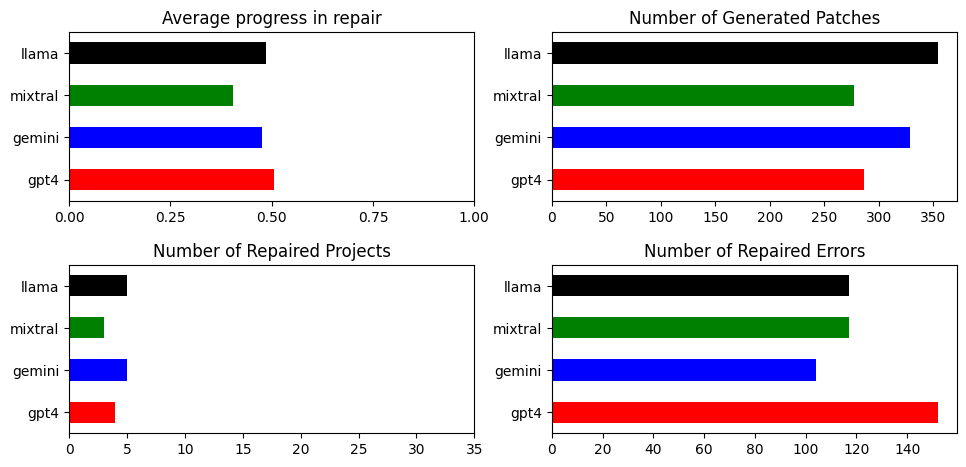

In [70]:
stats = get_stats_per_model("baseline", "with_diff")
plot_stats(stats, "baseline_with_diff")

## Standard
### Without api diff

In [71]:
stats = get_stats_per_model("standard", "without_diff")
pd.DataFrame(stats)

benchmark/20240524_without_diff/bump/standard/gpt4/report.json does not exist


TypeError: 'NoneType' object is not iterable

In [ ]:
stats = get_stats_per_model("standard", "without_diff")
plot_stats(stats, "standard_no_diff")

## With api diff

In [ ]:
stats = get_stats_per_model("standard", "with_diff")
pd.DataFrame(stats)

In [ ]:
stats = get_stats_per_model("standard", "with_diff")
plot_stats(stats, "standard_with_diff")

## Advanced
### With API Diff

In [ ]:
stats = get_stats_per_model("advanced", "with_diff")
pd.DataFrame(stats)

In [ ]:
stats = get_stats_per_model("advanced", "with_diff")
plot_stats(stats, "advanced_with_diff")